

---


- [CHIRPS](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY?hl=pt-br): `DESDE 1981` - `DIÁRIO` - `5566m` - `2 MESES DE ATRASO`

- [IMERGE](https://developers.google.com/earth-engine/datasets/catalog/NASA_GPM_L3_IMERG_V07?hl=pt-br): `DESDE 2000` - `A CADA 30 MIN` - `11132m` - `2 DIAS DE ATRASO` - **MELHOR OPÇÃO**

- [GSMAP](https://developers.google.com/earth-engine/datasets/catalog/JAXA_GPM_L3_GSMaP_v8_operational?hl=pt-br): `DESDE 1998` - `A CADA 1 HORA` - `11132m` - `2 DIAS DE ATRASO`




---




# Instalando Xee e inicializando GEE

Se você tiver uma conta do Earth Engine você poderá encontrar a sua ID de um projeto do GEE acessando https://code.earthengine.google.com/ com sua conta google, e depois verificando do lado superior direito do Code Editor o nome da sua ID.

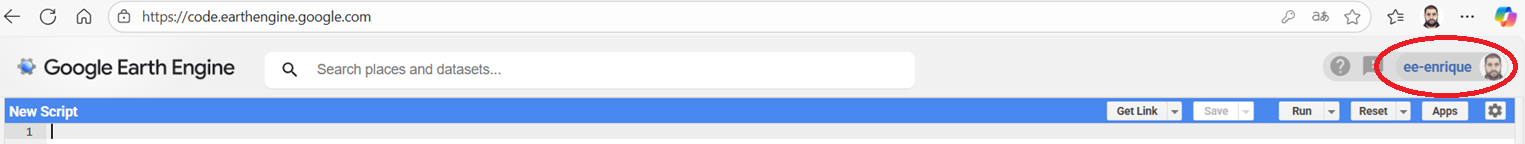

Insira a sua ID no campo `geemap.ee_initialize(project='SUA ID')`.

In [6]:
# instalando Xee
!pip install -q xee

# importa bibliotecas
import ee
import geemap
import xee
import xarray as xr
import time
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/2-PESQUISA/1-ORIENTACOES/TFG_NATANAEL'

# inicializando pelo GEE
geemap.ee_initialize(project='ee-enrique', opt_url='https://earthengine-highvolume.googleapis.com')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Processamento

In [ ]:
%%time
# define a região de interesse: queremos a área do Brasil
brasil = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil'))
#mg = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Minas Gerais'))

# define o ano de processamento
ano = '2024'

# função de agrupamento DIÁRIO
def diario(data, col):
    data_i = ee.Date(data)
    data_f = data_i.advance(1, 'day')
    soma_diaria = col.filterDate(data_i, data_f).sum()
    return soma_diaria.set('system:time_start', data_i.millis())

# loop dos meses
for file in pd.date_range(f'{ano}0101', f'{ano}1231', freq='ME'):

    # extrai ano e mês
    ano = file.strftime('%Y')
    mes = file.strftime('%m')

    # monta data no formato "2024-01-01"
    date = f"{ano}-{mes}-01"

    print('#-------------------------------------------#')
    print(f' PROCESSANDO =====>>>>: {date}')
    print('#-------------------------------------------#')

    # mês atual
    mes_atual = ee.Date(date)

    # próximo mês
    mes_prox = mes_atual.advance(1, 'month')

    # dia inicial e final do mês no formato string
    data_string_i = mes_atual.format('YYYY-MM-dd')
    data_string_f = mes_prox.format('YYYY-MM-dd')

    print('Data Inicial:', data_string_i.getInfo())
    print('Data Final', data_string_f.getInfo())
    print('#-------------------------------------------#')
    print('\n')

    # CHIRPS - "precipitation" (1 dia) - mm/d
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
               .filterDate(mes_atual, mes_prox) \
               .select(['precipitation'], ['precip_chirps']) \
               .map(lambda img: img.clip(brasil).copyProperties(img, img.propertyNames()))

    # IMERGE - "precipitation" (30 min) - mm/h
    imerge = ee.ImageCollection("NASA/GPM_L3/IMERG_V07") \
               .filterDate(mes_atual, mes_prox) \
               .select(['precipitation'], ['precip_imerge']) \
               .map(lambda img: img.multiply(0.5).copyProperties(img, ['system:time_start'])) \
               .map(lambda img: img.clip(brasil).copyProperties(img, img.propertyNames()))

    # GSMAP - "hourlyPrecipRate" (1 hora) - mm/h
    gsmap = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v8/operational') \
              .filterDate(mes_atual, mes_prox) \
              .select(['hourlyPrecipRate'], ['precip_gsmap']) \
              .map(lambda img: img.clip(brasil).copyProperties(img, img.propertyNames()))

    # diferença de datas em DIAS
    data_dif = mes_prox.difference(mes_atual, 'day').round()

    # lista dos dias
    lista_datas = ee.List.sequence(0, ee.Number(data_dif).subtract(1)).map(lambda x: mes_atual.advance(x, 'day'))

    # agrupamento DIÁRIO para todas as coleções
    chirps_diario = ee.ImageCollection(lista_datas.map(lambda x: diario(x, chirps)))
    imerge_diario = ee.ImageCollection(lista_datas.map(lambda x: diario(x, imerge)))
    gsmap_diario = ee.ImageCollection(lista_datas.map(lambda x: diario(x, gsmap)))

    # combina os campos do chirps, imerge e gsmap
    precip_combinada = chirps_diario.combine(imerge_diario).combine(gsmap_diario)

    # gera dataset
    ds = xr.open_dataset(precip_combinada,
                         engine = 'ee',
                         crs = 'EPSG:4326',
                         scale = 0.50,
                         geometry = brasil.geometry())
    ds.to_netcdf(f'{dir}/output/precipitacao_diaria_brasil_chirps_imerge_gsmap_50km_{ano}-{mes}.nc')

#-------------------------------------------#
 PROCESSANDO =====>>>>: 2024-01-01
#-------------------------------------------#
Data Inicial: 2024-01-01
Data Final 2024-02-01
#-------------------------------------------#




In [ ]:
mes_atual

In [ ]:
mes_prox

In [ ]:
lista_datas

In [ ]:
data_dif

In [ ]:
chuva = xr.open_dataset(f'{dir}/output/precipitacao_diaria_chirps_imerge_gsmap_15km_2024-01.nc')
chuva

In [ ]:
# gráfico: GPM
ds = xr.open_dataset(f'{dir}/output/precipitacao_diaria_chirps_imerge_gsmap_15km_2024-01.nc')
ds = ds.sortby('time')
ds.precip_chirps.plot(x = 'lon',
                      y = 'lat',
                      col = 'time',
                      col_wrap = 5,
                      robust = True,
                      cmap = 'jet',
                      vmin = 0.1,
                      vmax = 50)

In [ ]:
# gráfico: IMERGE
ds.precip_imerge.plot(x = 'lon',
                      y = 'lat',
                      col = 'time',
                      col_wrap = 5,
                      robust = True,
                      cmap = 'jet',
                      vmin = 0.1,
                      vmax = 50)

In [ ]:
# gráfico: GSMAP
ds.precip_gsmap.plot(x = 'lon',
                      y = 'lat',
                      col = 'time',
                      col_wrap = 5,
                      robust = True,
                      cmap = 'jet',
                      vmin = 0.1,
                      vmax = 50)